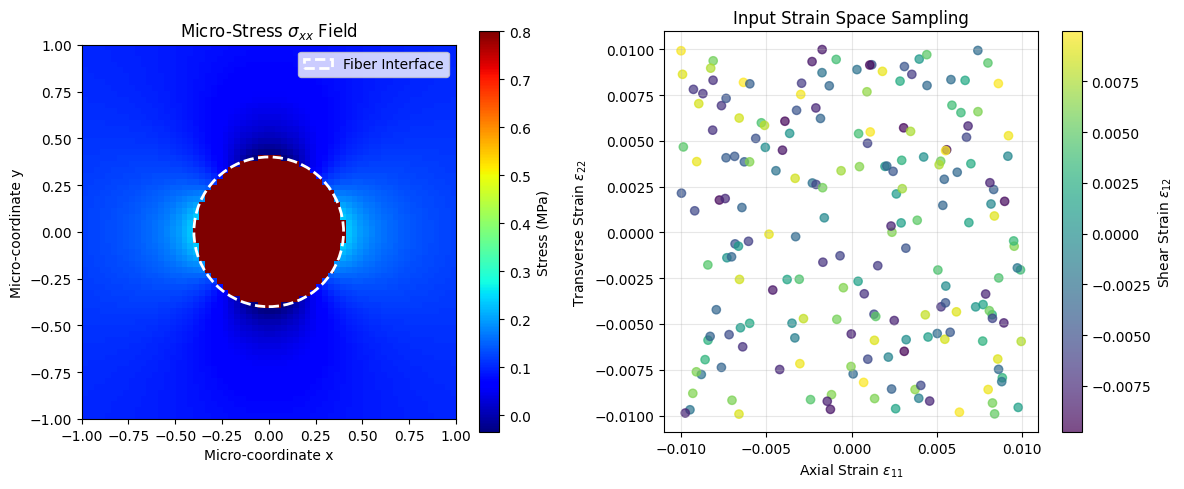

In [2]:
import numpy as np
import matplotlib.pyplot as plt

nx, ny = 64, 64
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)

radius = 0.4
R_dist = np.sqrt(X**2 + Y**2)
mask_fiber = R_dist <= radius

E_matrix = 10.0
E_fiber = 100.0
nu = 0.3

def compute_rve_stress(epsilon_11, epsilon_22, epsilon_12):
    factor = E_matrix / (1 - nu**2)
    sig_inf_xx = factor * (epsilon_11 + nu * epsilon_22)
    sig_inf_yy = factor * (epsilon_22 + nu * epsilon_11)
    sig_inf_xy = factor * (1 - nu) * epsilon_12

    R_safe = np.maximum(R_dist, 1e-6)
    theta = np.arctan2(Y, X)

    perturbation = (radius / R_safe)**2

    sigma_xx = np.full_like(X, sig_inf_xx)
    sigma_xx[~mask_fiber] += sig_inf_xx * 1.5 * perturbation[~mask_fiber] * np.cos(2*theta[~mask_fiber])
    sigma_xx[mask_fiber] = sig_inf_xx * (E_fiber/E_matrix) * 0.8

    sigma_yy = np.full_like(Y, sig_inf_yy)
    sigma_yy[~mask_fiber] -= sig_inf_yy * 1.5 * perturbation[~mask_fiber] * np.cos(2*theta[~mask_fiber])
    sigma_yy[mask_fiber] = sig_inf_yy * (E_fiber/E_matrix) * 0.8

    sigma_xy = np.full_like(X, sig_inf_xy)
    sigma_xy[~mask_fiber] += sig_inf_xy * perturbation[~mask_fiber] * np.sin(2*theta[~mask_fiber])
    sigma_xy[mask_fiber] = sig_inf_xy * (E_fiber/E_matrix) * 0.8

    return sigma_xx, sigma_yy, sigma_xy

n_samples = 200
input_strains = np.random.uniform(-0.01, 0.01, (n_samples, 3))

sigma_xx_snapshots = []

for i in range(n_samples):
    exx, eyy, exy = input_strains[i]
    s_xx, s_yy, s_xy = compute_rve_stress(exx, eyy, exy)
    sigma_xx_snapshots.append(s_xx.flatten())

sigma_xx_snapshots = np.array(sigma_xx_snapshots).T

exx_test, eyy_test, exy_test = 0.01, -0.003, 0.0
s_xx_test, s_yy_test, s_xy_test = compute_rve_stress(exx_test, eyy_test, exy_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title(r"Micro-Stress $\sigma_{xx}$ Field")
plt.imshow(s_xx_test, cmap='jet', extent=[-1, 1, -1, 1], origin='lower')
plt.colorbar(label='Stress (MPa)')
plt.xlabel('Micro-coordinate x')
plt.ylabel('Micro-coordinate y')

circle = plt.Circle((0, 0), radius, color='white', fill=False, linestyle='--', linewidth=2, label='Fiber Interface')
plt.gca().add_patch(circle)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title("Input Strain Space Sampling")
plt.scatter(input_strains[:,0], input_strains[:,1], c=input_strains[:,2], cmap='viridis', alpha=0.7)
plt.colorbar(label=r'Shear Strain $\epsilon_{12}$')
plt.xlabel(r'Axial Strain $\epsilon_{11}$')
plt.ylabel(r'Transverse Strain $\epsilon_{22}$')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Epoch 0, Loss: 19.833622
Epoch 1000, Loss: 0.001969
Epoch 2000, Loss: 0.000114
Epoch 3000, Loss: 0.000031
Epoch 4000, Loss: 0.000038


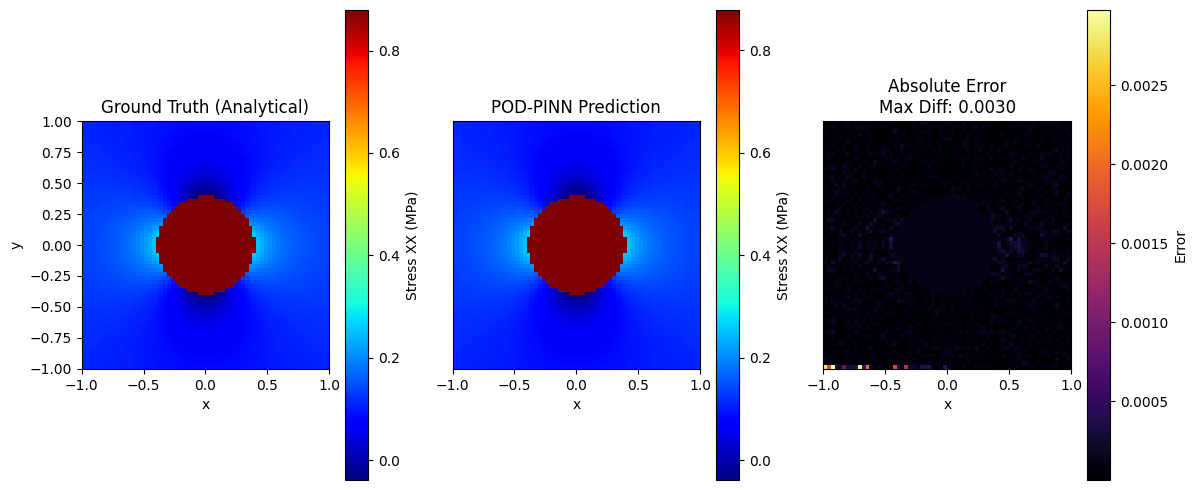

Relative L2 Error: 0.04%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.linalg as la

input_scaler = 100.0
X_train = input_strains * input_scaler
X_tensor = torch.tensor(X_train, dtype=torch.float32)

U, S, Vh = la.svd(sigma_xx_snapshots, full_matrices=False)
R_micro = 8
Phi_micro = U[:, :R_micro]

a_target = (Phi_micro.T @ sigma_xx_snapshots).T
y_tensor = torch.tensor(a_target, dtype=torch.float32)

class MicroStressPINN(nn.Module):
    def __init__(self, num_modes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, num_modes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_micro = MicroStressPINN(num_modes=R_micro).to(device)
optimizer = optim.Adam(model_micro.parameters(), lr=0.001)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

history = []

for epoch in range(5000):
    optimizer.zero_grad()
    a_pred = model_micro(X_tensor)
    loss = torch.mean((a_pred - y_tensor)**2)
    loss.backward()
    optimizer.step()
    history.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

test_strain = np.array([[0.01, 0.0, 0.005]])
test_input_scaled = torch.tensor(test_strain * input_scaler, dtype=torch.float32).to(device)

s_xx_true, _, _ = compute_rve_stress(test_strain[0,0], test_strain[0,1], test_strain[0,2])

model_micro.eval()
with torch.no_grad():
    a_pred_test = model_micro(test_input_scaled).cpu().numpy()

s_xx_pred = (Phi_micro @ a_pred_test.T).reshape(nx, ny)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Ground Truth (Analytical)")
plt.imshow(s_xx_true, cmap='jet', origin='lower', extent=[-1,1,-1,1])
plt.colorbar(label='Stress XX (MPa)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 3, 2)
plt.title("POD-PINN Prediction")
plt.imshow(s_xx_pred, cmap='jet', origin='lower', extent=[-1,1,-1,1])
plt.colorbar(label='Stress XX (MPa)')
plt.xlabel('x')
plt.yticks([])

diff = np.abs(s_xx_true - s_xx_pred)
plt.subplot(1, 3, 3)
plt.title(f"Absolute Error\nMax Diff: {np.max(diff):.4f}")
plt.imshow(diff, cmap='inferno', origin='lower', extent=[-1,1,-1,1])
plt.colorbar(label='Error')
plt.xlabel('x')
plt.yticks([])

plt.tight_layout()
plt.show()

norm_true = np.linalg.norm(s_xx_true)
if norm_true < 1e-6: norm_true = 1.0

err = np.linalg.norm(s_xx_true.flatten() - s_xx_pred.flatten()) / norm_true
print(f"Relative L2 Error: {err*100:.2f}%")